In [12]:
# 📌 외부 py 파일 수정 시 자동으로 재로드되도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of modeling.kmeans_model failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/25bigdata/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/masterj/Documents/GitHub/2025-1-Big-Data-Programming/src/modeling/kmeans_model.py", line 2, in <module>
    df: pd.DataFrame,
NameError: name 'pd' is not defined
]


In [15]:
# ================================================
# 📦 공통 패키지 import
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys

# src 경로 추가
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# seaborn 스타일 설정
sns.set(style="whitegrid")

# ================================================
# ⚙️ 경로 및 상수 설정
# ================================================
DATA_DIR = "../data/processed"
OUTPUT_DIR = "../data/modeling"
SEOUL_STATION_PATH = os.path.join(DATA_DIR, "seoul_env_station_mapped.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans 설정
KMEANS_MODE = "auto" # auto, manual
KMEANS_MANUAL_K = 5

# XGBoost 설정
XGB_N_ESTIMATORS = 100

# MCLP 설정
COVERAGE_RADIUS = 0.005
FACILITY_LIMIT = 30

# ================================================
# 🧪 평가 함수 import
# ================================================
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# ================================================
# 🧠 모델 함수 import
# ================================================
from modeling.kmeans_model import run_kmeans

# K means

In [16]:
# 데이터 로드
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# 수요가 가장 높은 클러스터만 추출
grid = run_kmeans(
    grid,
    mode=KMEANS_MODE,
    # manual_k=KMEANS_MANUAL_K,
    return_top_cluster_only=True
)

Finding optimal k:   0%|          | 0/9 [00:00<?, ?it/s]

Finding optimal k: 100%|██████████| 9/9 [00:00<00:00, 17.88it/s]


[AUTO MODE] 최적 k = 2
Inertia by k: {2: 394878040.6060905, 3: 182752136.79175264, 4: 111630868.37625772, 5: 83130803.13068569, 6: 65292788.3815513, 7: 54917904.7908943, 8: 48181642.39693806, 9: 36633734.731904596, 10: 32347245.131689377}

[Cluster별 평균 수요]
cluster
1    1360.575095
0      57.366915
Name: demand_score, dtype: float64

[필터링] 수요가 가장 높은 클러스터 (cluster=1)만 반환됨.


In [17]:
# 필요한 컬럼만 유지
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]

# grid_features.csv 로드
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# KMeans로 추출한 수요 밀집 클러스터와 병합 (grid_id 기준)
features = features_all.merge(grid, on='grid_id', how='inner')

# cluster 정수형 처리 (모델 입력을 위해)
features['cluster'] = features['cluster'].astype(int)

# 확인
print(f"전체 feature 수: {len(features_all)}")
print(f"수요 밀집 클러스터 feature 수: {len(features)}")
print(f"병합 후 유지된 비율: {len(features) / len(features_all) * 100:.2f}%")
print(f"사용 가능한 feature 컬럼: {features.columns.tolist()}")

전체 feature 수: 6030
수요 밀집 클러스터 feature 수: 526
병합 후 유지된 비율: 8.72%
사용 가능한 feature 컬럼: ['grid_id', 'center_lat_x', 'center_lon_x', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'center_lat_y', 'center_lon_y', 'cluster']


# XGBoost

결측치 제거 후 학습 데이터 수: 526
📊 XGBoost 성능:
MAE: 51.13
RMSE: 81.49
R²: 0.9826


/Users/masterj/Documents/GitHub/2025-1-Big-Data-Programming/src/modeling/xgboost_model.py:69: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


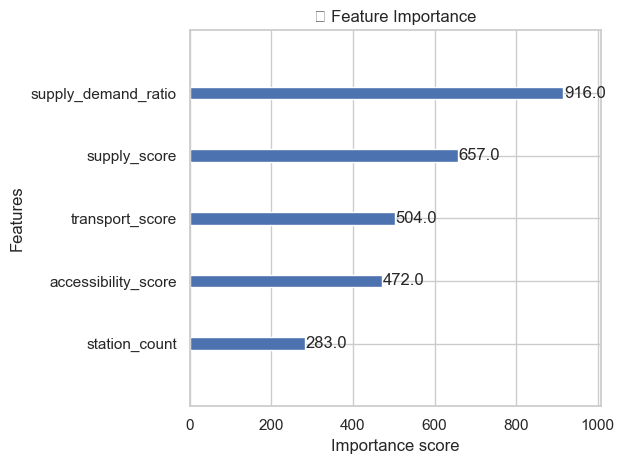

✅ XGBoost 예측 성능: {'MAE': 51.13, 'RMSE': 81.49, 'R2': 0.9826}


In [20]:
from modeling.xgboost_model import train_and_predict

# 🔍 성능 향상을 위한 feature 확장
selected_features = [
    'supply_score', 'station_count', 'commercial_count',
    'supply_demand_ratio', 'population_density',
    'accessibility_score', 'transport_score',
    'cluster'
]

# 결측치 로그
valid_rows = features.dropna(subset=selected_features + ['demand_score'])
print(f"결측치 제거 후 학습 데이터 수: {len(valid_rows)}")

# XGBoost 학습 및 예측
features, metrics = train_and_predict(
    df=features,
    features=selected_features,
    label='demand_score',                # ← 기존 target_column -> label로 바뀜
    n_estimators=XGB_N_ESTIMATORS,
    verbose=True                         # ← 성능 지표와 중요도 시각화 보기
)

# 예측 결과 존재 여부 확인
assert 'predicted_demand_score' in features.columns, "예측 결과 칼럼 누락"

# 저장
features.to_csv(f"{DATA_DIR}/grid_features_with_prediction.csv", index=False)
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/xgboost_metrics.csv", index=False)

print("✅ XGBoost 예측 성능:", metrics)

# MCLP

In [21]:
from modeling.mclp_model import solve_mclp

features = features.rename(columns={
    'center_lat_x': 'center_lat',
    'center_lon_x': 'center_lon'
})

# MCLP 실행
features = solve_mclp(
    df=features,
    coverage_radius=COVERAGE_RADIUS,
    facility_limit=FACILITY_LIMIT,
    demand_column='predicted_demand_score'
)

# 결과 저장
features.to_csv(f"{OUTPUT_DIR}/mclp_selected_sites.csv", index=False)

# 설치 위치 확인
selected = features[features['selected'] == 1]
print(f"설치 대상지 수: {len(selected)}")
print(f"커버 수요 총합: {selected['predicted_demand_score'].sum():,.2f}")

🧩 제약조건 생성 중: 100%|██████████| 526/526 [00:00<00:00, 26577.57it/s]


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/d2041742f9954f2fab35e7b37d88e7fe-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/d2041742f9954f2fab35e7b37d88e7fe-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 532 COLUMNS
At line 5817 RHS
At line 6345 BOUNDS
At line 7398 ENDATA
Problem MODEL has 527 rows, 1052 columns and 2654 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 275612 - 0.01 seconds
Cgl0004I processed model has 476 rows, 985 columns (985 integer (969 of which binary)) and 2504 elements
Cbc0038I Initial state - 51 integers unsatisfied sum - 13.8182
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. -270146 iteratio

# 평가

In [22]:
print("'selected' in features.columns:", 'selected' in features.columns)
print(features['selected'].value_counts() if 'selected' in features.columns else "selected 열 없음")

'selected' in features.columns: True
selected
0    496
1     30
Name: count, dtype: int64


In [23]:
features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_sites.csv")

# ✅ 기존 충전소 데이터 변경
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")

# 📊 평가 실행
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='위도',
    lon_col='경도'
)
baseline2 = evaluate_random_installation(features, n=FACILITY_LIMIT)
baseline3 = evaluate_cluster_centers(features)
baseline4 = evaluate_mclp_result(features, facility_limit=FACILITY_LIMIT)

[Baseline ① 기존 충전소 기준]
- 설치 격자 수: 523
- 커버 수요: 712,847.65
- 전체 수요: 716,087.70
- 커버율: 99.55%
[Baseline ② 랜덤 설치]
- 설치 격자 수: 30
- 커버 수요: 38,727.62
- 전체 수요: 716,087.70
- 커버율: 5.41%
[Baseline ③ 클러스터 중심 설치]
- 설치 격자 수: 1
- 커버 수요: 797.63
- 전체 수요: 716,087.70
- 커버율: 0.11%
[📊 MCLP 성능 평가]
- 설치 개수: 30
- 총 수요: 716,087.70
- 커버 수요: 63,445.20
- Coverage Rate: 8.86%
- Demand Satisfaction Ratio (DSR): 2,114.84
- 설치 효율성 (grid 단위): 2,114.84


In [24]:
results = pd.DataFrame([
    {'baseline': '① 기존 충전소', **baseline1},
    {'baseline': '② 랜덤 설치', **baseline2},
    {'baseline': '③ 클러스터 중심', **baseline3},
    {'baseline': '④ MCLP 최적화', **baseline4}
])

from IPython.display import display
display(results)

,baseline,coverage,coverage_rate,covered_grids,dsr,efficiency,selected,total_demand
0,① 기존 충전소,712847.646545,99.547534,523.0,NaN,NaN,NaN,NaN
1,② 랜덤 설치,38727.618958,5.408223,30.0,NaN,NaN,NaN,NaN
2,③ 클러스터 중심,797.631165,0.111387,1.0,NaN,NaN,NaN,NaN
3,④ MCLP 최적화,63445.195374,8.859976,NaN,2114.839846,2114.839846,30.0,716087.700928


/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/1391480480.py:21: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


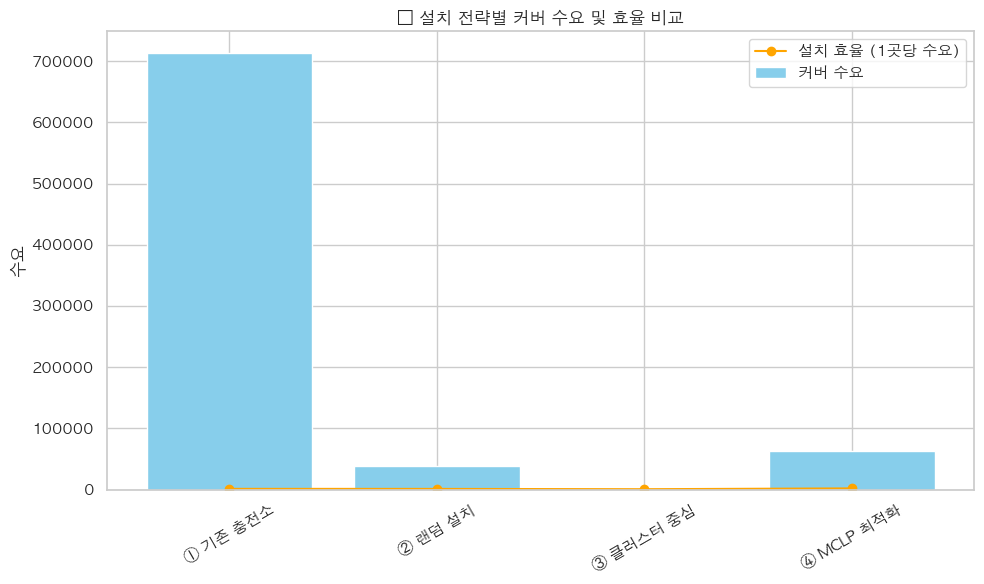

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# ✅ 한글 폰트 설정 (OS에 맞게 선택)
mpl.rcParams['font.family'] = 'AppleGothic'  # macOS
# mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows
mpl.rcParams['axes.unicode_minus'] = False

df = results.copy()
df['selected'] = df['selected'].fillna(df['covered_grids'])

plt.figure(figsize=(10, 6))
plt.bar(df['baseline'], df['coverage'], color='skyblue', label='커버 수요')
plt.plot(df['baseline'], df['coverage'] / df['selected'], color='orange', marker='o', label='설치 효율 (1곳당 수요)')

plt.xticks(rotation=30)
plt.ylabel("수요")
plt.title("⚡ 설치 전략별 커버 수요 및 효율 비교")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
import folium
from geopy.distance import geodesic
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0):
    """
    여러 설치 전략을 한 지도에 격자 커버리지를 색상별로 구분하여 시각화

    Parameters:
    - features: 전체 grid DataFrame (center_lat, center_lon 포함)
    - strategy_dict: {label: 설치지 DataFrame} 형식
    - radius_km: 커버 반경
    """
    # 지도 초기화 (서울 중심)
    m = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='cartodbpositron')

    # 고유 색상 설정
    color_map = {
        '① 기존 충전소': 'red',
        '② 랜덤 설치': 'green',
        '③ 클러스터 중심': 'purple',
        '④ MCLP 최적화': 'blue'
    }

    for label, install_df in strategy_dict.items():
        color = color_map[label]

        for _, grid in features.iterrows():
            grid_center = (grid['center_lat'], grid['center_lon'])
            for _, site in install_df.iterrows():
                site_center = (site['center_lat'], site['center_lon'])
                if geodesic(grid_center, site_center).km <= radius_km:
                    folium.CircleMarker(
                        location=grid_center,
                        radius=2.5,
                        color=color,
                        fill=True,
                        fill_opacity=0.3,
                        popup=f"{label} 커버"
                    ).add_to(m)
                    break

        # 설치 위치 강조
        for _, site in install_df.iterrows():
            folium.Marker(
                location=(site['center_lat'], site['center_lon']),
                icon=folium.Icon(color=color, icon='bolt', prefix='fa'),
                popup=f"{label} 설치지"
            ).add_to(m)

    return m

In [ ]:
# 기존 충전소
existing_stations_df = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
existing_stations_df = existing_stations_df.dropna(subset=['위도', '경도']).copy()
existing_stations_df = existing_stations_df.rename(columns={'위도': 'center_lat', '경도': 'center_lon'})

# MCLP 설치지
mclp_selected_df = features[features['selected'] == 1][['grid_id', 'center_lat', 'center_lon']].copy()

# 랜덤 설치
np.random.seed(42)
random_sites_df = features.sample(n=FACILITY_LIMIT)[['grid_id', 'center_lat', 'center_lon']].copy()

# 클러스터 중심 (각 클러스터마다 중심 1개씩)
cluster_center_df = features.groupby('cluster')[['center_lat', 'center_lon']].mean().reset_index()

# 전략별 dict
strategy_dict = {
    "① 기존 충전소": existing_stations_df,
    "② 랜덤 설치": random_sites_df,
    "③ 클러스터 중심": cluster_center_df,
    "④ MCLP 최적화": mclp_selected_df
}

# 지도 생성 및 저장
map_all = plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0)
map_all.save("../outputs/maps/coverage_comparison_map.html")
map_all